In [4]:
#EV Vehicle/Charging Demand Prediction Project
# Electric Vehicle Adoption Forecasting for Washington State

# ================================
# 1. SETUP AND LIBRARY IMPORTS
# ================================

In [5]:
# Install required libraries
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn plotly

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
# ================================
# 2. DATA LOADING AND EXPLORATION
# ================================

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# Load the dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Electric_Vehicle_Population_Size_History_By_County_.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


Dataset loaded successfully!
Dataset shape: (20819, 10)
Date range: 2017-01-31 00:00:00 to 2024-02-29 00:00:00


In [10]:
# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
df.info()

print("\n" + "="*50)
print("FIRST 5 ROWS")
print("="*50)
print(df.head())

print("\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(df.describe())


DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), o

In [11]:
# ================================
# 3. DATA PREPROCESSING
# ================================

In [41]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Show missing values
print("\nMissing values per column before filling:")
print(df.isnull().sum())

# Fill missing values with 0
df.fillna(0, inplace=True)

# Create new time-based columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# Ensure vehicle count columns are numeric
df['Electric Vehicle (EV) Total'] = pd.to_numeric(df['Electric Vehicle (EV) Total'], errors='coerce').fillna(0)
df['Total Vehicles'] = pd.to_numeric(df['Total Vehicles'], errors='coerce').fillna(0)

# Calculate EV Penetration Rate (in percentage)
df['EV_Penetration_Rate'] = (df['Electric Vehicle (EV) Total'] / df['Total Vehicles']) * 100

# Sort the DataFrame by date for time series analysis
df.sort_values('Date', inplace=True)

# Final confirmation
print("\nData preprocessing completed successfully!")
print(f"Date range       : {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Number of counties: {df['County'].nunique()}")
print(f"Vehicle use types : {df['Vehicle Primary Use'].unique()}")


DATA PREPROCESSING

Missing values per column before filling:
Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

Data preprocessing completed successfully!
Date range       : 2017-01-31 to 2024-02-29
Number of counties: 312
Vehicle use types : ['Passenger' 'Truck']


In [16]:
# Create aggregated data for state-level analysis
state_monthly = df.groupby(['Date', 'Year', 'Month']).agg({
    'Battery Electric Vehicles (BEVs)': 'sum',
    'Plug-In Hybrid Electric Vehicles (PHEVs)': 'sum',
    'Electric Vehicle (EV) Total': 'sum',
    'Non-Electric Vehicle Total': 'sum',
    'Total Vehicles': 'sum'
}).reset_index()

# Recalculate EV Penetration Rate
state_monthly['EV_Penetration_Rate'] = (state_monthly['Electric Vehicle (EV) Total'] /
                                        state_monthly['Total Vehicles']) * 100

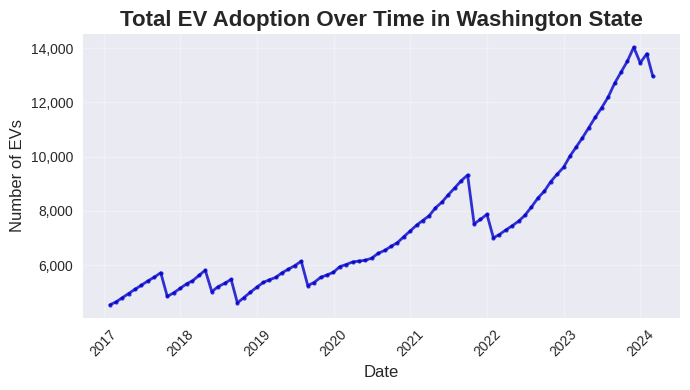

In [21]:
import matplotlib.ticker as mtick

plt.figure(figsize=(7, 4))
plt.plot(state_monthly['Date'], state_monthly['Electric Vehicle (EV) Total'],
         marker='o', linewidth=2, markersize=3, color='mediumblue', alpha=0.8)

plt.title('Total EV Adoption Over Time in Washington State', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of EVs', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Adds commas to y-axis
plt.tight_layout()
plt.show()

In [54]:
# First: Remove commas and whitespace, then convert to numeric
state_monthly['Battery Electric Vehicles (BEVs)'] = pd.to_numeric(
    state_monthly['Battery Electric Vehicles (BEVs)'].astype(str).str.replace(',', '').str.strip(),
    errors='coerce'
)

state_monthly['Plug-In Hybrid Electric Vehicles (PHEVs)'] = pd.to_numeric(
    state_monthly['Plug-In Hybrid Electric Vehicles (PHEVs)'].astype(str).str.replace(',', '').str.strip(),
    errors='coerce'
)

# Optional: Check what we got
print("BEV unique:", state_monthly['Battery Electric Vehicles (BEVs)'].unique())
print("PHEV unique:", state_monthly['Plug-In Hybrid Electric Vehicles (PHEVs)'].unique())

# Now drop rows with missing values in these columns
state_monthly = state_monthly.dropna(
    subset=['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)']
)

BEV unique: []
PHEV unique: []


In [55]:
print(df[['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)']].head(10))

      Battery Electric Vehicles (BEVs)  \
8970                                 1   
3493                                 1   
20411                                0   
7518                                 0   
10779                              822   
4356                                 2   
2275                                 1   
16608                                0   
19651                                1   
5236                                 0   

      Plug-In Hybrid Electric Vehicles (PHEVs)  
8970                                         0  
3493                                         0  
20411                                        1  
7518                                         0  
10779                                      751  
4356                                         0  
2275                                         0  
16608                                        1  
19651                                        1  
5236                                         0 

In [56]:
print("BEV unique:", df['Battery Electric Vehicles (BEVs)'].unique())
print("PHEV unique:", df['Plug-In Hybrid Electric Vehicles (PHEVs)'].unique())

BEV unique: ['1' '0' '822' ... '691' '3,002' '3,016']
PHEV unique: ['0' '1' '751' '3' '196' '7' '32' '31' '2' '28' '803' '4' '21' '24' '119'
 '44' '22' '6' '426' '19' '64' '299' '81' '141' '3,620' '15' '53' '42'
 '262' '58' '129' '49' '16' '61' '824' '122' '46' '86' '55' '146' '3,712'
 '33' '434' '18' '50' '309' '778' '133' '280' '29' '36' '202' '48' '130'
 '47' '91' '3,786' '26' '20' '848' '289' '34' '30' '23' '65' '57' '454'
 '313' '784' '139' '156' '63' '8' '471' '56' '298' '140' '62' '54' '860'
 '17' '208' '97' '35' '807' '319' '159' '68' '3,881' '25' '142' '38' '74'
 '167' '823' '866' '302' '5' '334' '489' '102' '3,989' '59' '211' '60'
 '27' '137' '37' '902' '175' '40' '842' '4,102' '76' '103' '45' '66' '143'
 '336' '504' '39' '517' '104' '324' '77' '69' '9' '350' '4,172' '179'
 '213' '919' '148' '856' '112' '4,265' '71' '150' '182' '359' '67' '941'
 '220' '79' '528' '147' '363' '190' '4,348' '898' '974' '346' '542' '229'
 '83' '120' '998' '355' '155' '126' '41' '72' '10' '154' '4

In [57]:
# Remove commas and convert to integers
df['Battery Electric Vehicles (BEVs)'] = df['Battery Electric Vehicles (BEVs)'].str.replace(',', '').astype(int)
df['Plug-In Hybrid Electric Vehicles (PHEVs)'] = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].str.replace(',', '').astype(int)

In [58]:
print(df['Battery Electric Vehicles (BEVs)'].unique()[:10])  # First 10 unique values
print(df['Battery Electric Vehicles (BEVs)'].dtype)          # Should be int

[  1   0 822   2   4 221   7  43  84   3]
int64


In [60]:
print(df.columns.tolist())

['Date', 'County', 'State', 'Vehicle Primary Use', 'Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)', 'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total', 'Total Vehicles', 'Percent Electric Vehicles', 'Year', 'Month', 'Quarter', 'EV_Penetration_Rate']


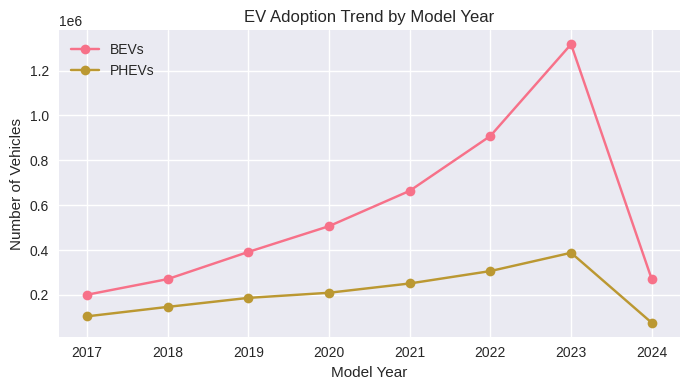

In [63]:
# 4.2 BEV vs PHEV Trends
import matplotlib.pyplot as plt

df_grouped = df.groupby('Year').sum(numeric_only=True)

plt.figure(figsize=(7, 4))
plt.plot(df_grouped.index, df_grouped['Battery Electric Vehicles (BEVs)'], label='BEVs', marker='o')
plt.plot(df_grouped.index, df_grouped['Plug-In Hybrid Electric Vehicles (PHEVs)'], label='PHEVs', marker='o')
plt.title('EV Adoption Trend by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()